In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import os
import matplotlib.pyplot as plt
import yaml
from concurrent.futures import ProcessPoolExecutor

from wire_detector_cpu import WireDetectorCPU
import viz_utils as vu

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
with open('wire_detect_config.yaml', 'r') as file:
    detection_config = yaml.safe_load(file)

folder = '/media/tyler/Storage/Research/Datasets/wire_tracking_05-07_40fov/'
# folder = '/media/tyler/Storage/field_tests/street_wire_experiments/wire_tracking_05-07_40fov/'
# folder = '/home/tyler/Documents/wire_tracking_05-07_40fov/'
target_timestamp = 1746650648952882464 # straight wire not working
# target_timestamp = 1746650644465219840 # straight wire
# target_timestamp = 1746650656862302432 # angled wire

# folder = '/media/tyler/Storage/field_tests/acfa_3-21/'
# target_timestamp = 1742581588251564064

# folder = '/media/tyler/Storage/field_tests/hawkins_2-19/wire_tracking_02-19_1/'
# target_timestamp = 1739975958352738816 # seperated wires
# target_timestamp = 1739975963786320032 # wires in a bundle
# target_timestamp = 1739975992503588928  # wires clean

rgb_folder = folder + 'rgb_images/'
depth_folder = folder + 'depth_images/'
camera_intrinsics_file = folder + 'rgb_camera_intrinsics.npy'
camera_intrinsics = np.load(camera_intrinsics_file)

closest_rgb_timestamp = None
closest_depth_timestamp = None
for image_name in os.listdir(rgb_folder):
    if image_name.endswith('.png'):
        timestamp = int(image_name.split('.')[0])
        if closest_rgb_timestamp is None or abs(timestamp - target_timestamp) < abs(closest_rgb_timestamp - target_timestamp):
            closest_rgb_timestamp = timestamp
            closest_rgb_timestamp_s = timestamp * 1e-9  # Convert to seconds
for image_name in os.listdir(depth_folder):
    if image_name.endswith('.npy'):
        timestamp = int(image_name.split('.')[0])
        if closest_depth_timestamp is None or abs(timestamp - target_timestamp) < abs(closest_depth_timestamp - target_timestamp):
            closest_depth_timestamp = timestamp
            closest_depth_timestamp_s = timestamp * 1e-9  # Convert to seconds

rgb_image_path = str(closest_rgb_timestamp) + '.png'
depth_image_path = str(closest_depth_timestamp) + '.npy'

print(f"Time difference between closest RGB and depth images: {abs(closest_rgb_timestamp_s - closest_depth_timestamp_s)}")
    
input_image_size = [480, 270] 
img = cv2.imread(rgb_folder + rgb_image_path)
depth = np.load(depth_folder + depth_image_path)
img = cv2.resize(img, (input_image_size[0], input_image_size[1]))
depth = cv2.resize(depth, (input_image_size[0], input_image_size[1]))
assert img is not None, "Image not found"
assert depth is not None, "Depth image not found"

original_image_size = img.shape[:2][::-1]  # (width, height)

# resize the camera intrinsics to match the input image size
camera_intrinsics[0, 0] *= input_image_size[0] / original_image_size[0]
camera_intrinsics[1, 1] *= input_image_size[1] / original_image_size[1]
camera_intrinsics[0, 2] *= input_image_size[0] / original_image_size[0]
camera_intrinsics[1, 2] *= input_image_size[1] / original_image_size[1]

wire_detector = WireDetectorCPU(detection_config, camera_intrinsics)


Time difference between closest RGB and depth images: 0.002839803695678711


Time taken for 2D wire detection: 0.00 seconds, 323.70 Hz


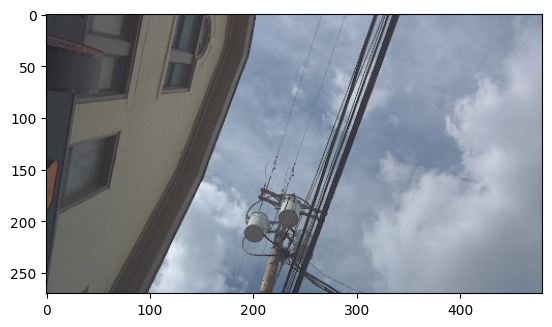

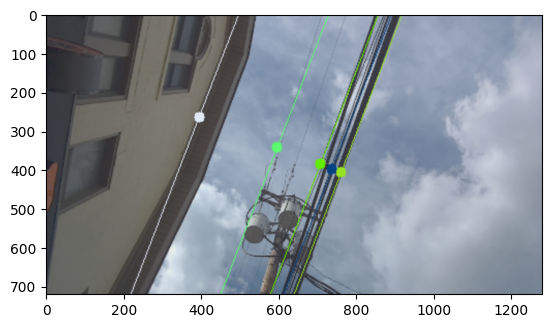

In [3]:
cv2.imwrite('detect_3d_output/reference.jpg', img)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Create segmentation mask
start_time = time.perf_counter()
wire_lines, wire_midpoints, avg_angle, midpoint_dists_wrt_center = wire_detector.detect_wires_2d(img)
end_time = time.perf_counter()
print(f"Time taken for 2D wire detection: {end_time - start_time:.2f} seconds, {1 / (end_time - start_time):.2f} Hz")

img_2d_detect = img.copy()
rand_colors = np.random.randint(0, 256, (len(wire_midpoints), 3)).tolist()
for i, (x0,y0,x1,y1) in enumerate(wire_lines):
    cv2.line(img_2d_detect, (x0,y0), (x1,y1), tuple(rand_colors[i]), 1)

for i, (x0,y0) in enumerate(wire_midpoints):
    cv2.circle(img_2d_detect, (int(x0), int(y0)), 5, tuple(rand_colors[i]), -1)
img_2d_detect = cv2.resize(img_2d_detect, (1280, 720))
cv2.imwrite('detect_3d_output/wire2d_detect.jpg', img_2d_detect)
plt.figure()
plt.imshow(cv2.cvtColor(img_2d_detect, cv2.COLOR_BGR2RGB))

Time taken to find regions of interest: 0.01 seconds, 168.50 Hz
Filtered Regions of Interest: [(np.float64(-26.947057694735634), np.float64(56.05294230526437))]
ROI Line Counts: [4]
Time taken for RANSAC on ROIs: 8.55 seconds, 0.12 Hz
Number of fitted lines: 3
Number of fitted lines from combined detection: 3


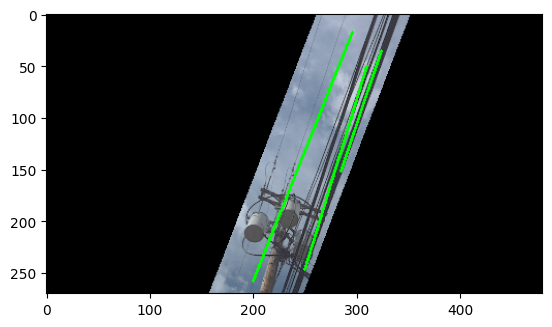

In [ ]:
start_time = time.perf_counter()
regions_of_interest, roi_line_counts = wire_detector.find_regions_of_interest(depth, avg_angle, midpoint_dists_wrt_center)
end_time = time.perf_counter()
print(f"Time taken to find regions of interest: {end_time - start_time:.2f} seconds, {1 / (end_time - start_time):.2f} Hz")
print(f"Filtered Regions of Interest: {regions_of_interest}")
print(f"ROI Line Counts: {roi_line_counts}")

start_time = time.perf_counter()
fitted_lines, roi_pcs, roi_point_colors, rgb_masked = wire_detector.ransac_on_rois(regions_of_interest, roi_line_counts, avg_angle, depth, viz_img=img)
end_time = time.perf_counter()
print(f"Time taken for RANSAC on ROIs: {end_time - start_time:.2f} seconds, {1 / (end_time - start_time):.2f} Hz")
print(f"Number of fitted lines: {len(fitted_lines)}")


for fitted_line in fitted_lines:
    rgb_masked = vu.draw_3d_line_on_image(rgb_masked, fitted_line, camera_intrinsics, color=(0, 255, 0), thickness=2)

cv2.imwrite('detect_3d_output/ransac_2d_projection.jpg', rgb_masked)
plt.figure()
plt.imshow(cv2.cvtColor(rgb_masked, cv2.COLOR_BGR2RGB))
plt.show()



In [ ]:
renderer, material = vu.create_renderer()
vu.capture_fitted_lines_in_image(renderer, material, "detect_3d_output/ransac_3d_rendering.png", fitted_lines, roi_pcs, roi_point_colors)

# visualize the fitted lines
# vu.visualize_fitted_lines(
#     fitted_lines,
#     roi_pcs,
#     roi_point_colors,
# )